In [1]:
import json
import matplotlib.pyplot as plt
from statistics import mean, variance
import numpy as np
import re

from kp.utils.constants import EXPERIMENTS_DIR

In [17]:
EXPERIMENT_NAME = "Fake Movies, Real Actors (No Patching)"
EXPERIMENT_DIR = re.sub(r"[^\w]", "_", EXPERIMENT_NAME).lower().replace("__","_").rstrip("_")
RESULTS_DIR = EXPERIMENTS_DIR / EXPERIMENT_DIR
FIGURES_DIR = RESULTS_DIR / "figures"
FIGURES_DIR.mkdir(exist_ok=True)
results_paths = RESULTS_DIR.rglob("*.json")

In [18]:
TOP_K = 20
forgotten_tokens = {}
results = []
for results_path in results_paths:
    with open(results_path, "r") as f:
        data = json.load(f)

    dropout_rate = data["inference_settings"]["patch_dropout"] if "patch_dropout" in data["inference_settings"] else 0.0

    target_probs = [
        ex["target"]["token_prob"]
        for ex in data["results"]
        if "target" in ex and "token_prob" in ex["target"]
    ]

    # TODO: Set this up with some sort of top k setup
    accuracy = [
        int(ex["target"]["token_idx"] == ex["top_predictions"][0]["token_id"])
        for ex in data["results"]
    ]

    avg_prob = mean(target_probs)
    avg_accuracy = mean(accuracy)
    var_prob = variance(target_probs)

    results.append({
        "dropout_rate": dropout_rate,
        "avg_prob": avg_prob,
        "var_prob": var_prob,
        "avg_accuracy": avg_accuracy,
    })

    lowest_k = sorted(data["results"], key=lambda ex: ex["target"]["token_prob"])[:TOP_K]

    forgotten_tokens[dropout_rate] = lowest_k


In [19]:
forgotten_tokens

{0.0: [{'ex_id': 772,
   'dropout_record': {'layers': []},
   'top_predictions': [{'token_id': 43971,
     'token': ' Angela',
     'probability': 0.997825026512146},
    {'token_id': 7939,
     'token': ' Michael',
     'probability': 0.00021063684835098684},
    {'token_id': 16188,
     'token': ' Alexander',
     'probability': 0.00018323426775168628},
    {'token_id': 3350,
     'token': ' John',
     'probability': 0.00012716134369838983},
    {'token_id': 50914,
     'token': 'Angela',
     'probability': 0.00011539678962435573},
    {'token_id': 21504,
     'token': ' Anthony',
     'probability': 4.27718878199812e-05},
    {'token_id': 8103,
     'token': ' Christian',
     'probability': 3.8110116292955354e-05},
    {'token_id': 9201, 'token': ' Lee', 'probability': 2.6611036446411163e-05},
    {'token_id': 106221,
     'token': ' Angie',
     'probability': 2.554072307248134e-05},
    {'token_id': 31918,
     'token': ' Julia',
     'probability': 2.545427742006723e-05},
    

In [22]:
for res in forgotten_tokens[0.0]:
    print(res["target"]["token_prob"])
    print(res["dropout_record"])

0.997825026512146
{'layers': []}
0.998492956161499
{'layers': []}
0.9988166093826294
{'layers': []}
0.9988791346549988
{'layers': []}
0.9992460012435913
{'layers': []}
0.9992948770523071
{'layers': []}
0.9993330836296082
{'layers': []}
0.9994361996650696
{'layers': []}
0.9994989633560181
{'layers': []}
0.9995068311691284
{'layers': []}
0.9995207786560059
{'layers': []}
0.9995342493057251
{'layers': []}
0.9995429515838623
{'layers': []}
0.999543309211731
{'layers': []}
0.9995538592338562
{'layers': []}
0.9995657801628113
{'layers': []}
0.9995773434638977
{'layers': []}
0.9995865225791931
{'layers': []}
0.9995874762535095
{'layers': []}
0.9996154308319092
{'layers': []}


In [13]:
dropout_rates = [r["dropout_rate"] for r in results]
avg_probs = [r["avg_prob"] for r in results]
std_devs = [np.sqrt(r["var_prob"]) for r in results]  # std = sqrt(variance)
avg_accuracies = [r["avg_accuracy"] for r in results]

sorted_data = sorted(zip(dropout_rates, avg_probs, std_devs, avg_accuracies))
x, y, yerr, z = zip(*sorted_data)

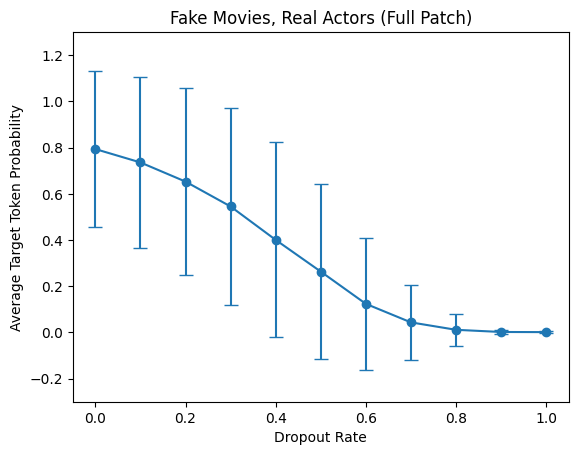

In [26]:
plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5)
plt.xlabel("Dropout Rate")
plt.ylabel("Average Target Token Probability")
plt.title(EXPERIMENT_NAME)
plt.ylim(-0.3, 1.3)
plt.savefig(FIGURES_DIR / "dropout_vs_prob.png", dpi=300, bbox_inches="tight")
plt.show()

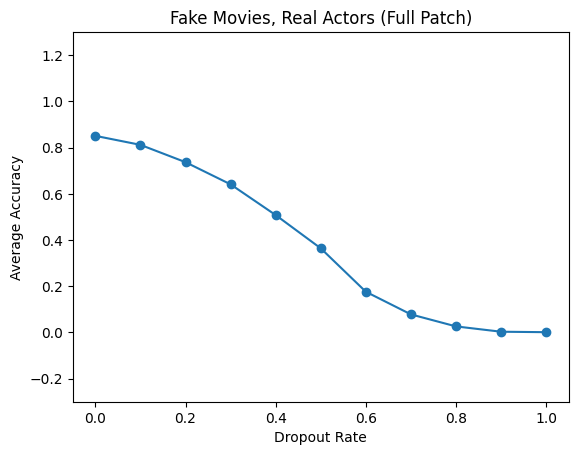

In [27]:
plt.errorbar(x, z, fmt='o-', capsize=5)
plt.xlabel("Dropout Rate")
plt.ylabel("Average Accuracy")
plt.title(EXPERIMENT_NAME)
plt.ylim(-0.3, 1.3)
plt.savefig(FIGURES_DIR / "dropout_vs_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()